Steane code error correction using software with noise
=============================================

1. Set up logical zero for Steane code based  on the parity matrix in the book by Nielsen MA, Chuang IL. Quantum Computation and Quantum Information, 10th Anniversary Edition. Cambridge University Press; 2016. p. 474

2. Set up the ancilla and measure the outputs.

3. Use ancilla measurements to correct the data using Python code and check that without noise all errors are corrected 

The simulation is run both with and without noise and the logical zero and logical one state are simulated.

There is an option to remove transpilation to assess the sensitivity.

Import the necessary function modules, including the SteaneCodeLogicalQubit class and helper functions.  The methods of this class are called in this notebook.

In [1]:
from qiskit import(
    QuantumCircuit,
    QuantumRegister,
    ClassicalRegister,
    execute,
    Aer
    )

from qiskit.providers.aer.noise import NoiseModel
from qiskit.providers.aer.noise.errors import pauli_error, depolarizing_error
from qiskit.compiler import transpile

from circuits import SteaneCodeLogicalQubit

import matplotlib.pyplot as plt
import numpy as np

from helper_functions import (
    count_valid_output_strings,
    find_individual_ancilla_values,
    find_ancilla_values,
    find_parity,
    string_reverse,
    strings_AND_bitwise,
    string_ancilla_mask,
    correct_qubit,
    flip_code_words,
    get_noise,
    mean_of_list,
    calculate_standard_error,
    get_parity_check_matrix,
    get_codewords
    )

Define constants so the process flow can be controlled from one place:

In [2]:
TRANSPILE = False             # controls if transpilation takes place to allow sensitivity check
TITLE = 'Simulation before and after correction'

# transpilation uses a different gate set
if TRANSPILE:
    SINGLE_GATE_SET = ['id', 'ry', 'rx']
    TWO_GATE_SET = ['rxx']
else:
    SINGLE_GATE_SET = ['id', 'x', 'y', 'z', 'h']
    TWO_GATE_SET = ['cx', 'cz']
BASIS_GATE_SET = SINGLE_GATE_SET + TWO_GATE_SET

DATA_QUBITS = 7
ANCILLA_QUBITS = 3

ERROR_REDUCTION = 1
SHOTS = 10000                                             #Number of shots to run    
MEASURE_NOISE = 0.0046 * ERROR_REDUCTION                  #Measurement noise not relevant
SINGLE_GATE_DEPOLARISING = 0.000366 * ERROR_REDUCTION     #Single gate noise   
TWO_GATE_DEPOLARISING = 0.022 * ERROR_REDUCTION 
ITERATIONS = 25

SIMULATOR = Aer.get_backend('qasm_simulator')
SPACE = ' '

We specify the parity check matrix, since this defines the Steane code.  It is validated before the logical qubit is initiated to check that it is orthogonal to the valid codewords.

In [3]:
parity_check_matrix = get_parity_check_matrix()
print(parity_check_matrix)

['0001111', '0110011', '1010101']


The allowed codewords for the zero logical from Nielsen and Chuang is stored in a list.  Note, the order of qubits in the list is reversed compared to the normal output of Qiskit.

In [4]:
codewords = get_codewords()
print(codewords)

['0000000', '1010101', '0110011', '1100110', '0001111', '1011010', '0111100', '1101001']


In [5]:
flipped_codewords = flip_code_words(codewords)

Error correction
-----------------------

The ancilla error detection circuit is added to the encoding circuit and transpiled if required.  Noise is applied and the error rate before is calculated.  Then, the ancilla measurements are used to correct the data measurement in software and the error rate after correction is calculated. 

In [6]:
#set up scenarios
scenarios = {
        'Logical_zero, no noise':{
            'Logical_one' : False, 'Noise' : False
           },
        'Logical_zero, noise':{
            'Logical_one' : False, 'Noise' : True
            },
        'Logical_one, no noise':{
            'Logical_one' : True, 'Noise' : False
            },
        'Logical_one, noise':{
            'Logical_one' : True, 'Noise' : True
            },
        }

In [7]:
def set_up_circuit():
    qubit = SteaneCodeLogicalQubit(1, parity_check_matrix, codewords)
    qubit.set_up_logical_zero()
    qubit.barrier()  
    if logical_one:
        qubit.logical_gate_X(0)
    qubit.barrier()
    qubit.set_up_ancilla()
    qubit.barrier()
    qubit.logical_measure_data()
    qubit.logical_measure_ancilla()
    qubit.barrier()
    return(qubit)

In [8]:
#initialise lists for graphs results
values_list = [[], [], [], []]
standard_error_list = [[], [], [], []]
labels_list = ['0L','1L']
cases_list = ['No_error_correction','Error_correction']
noise_model = get_noise(MEASURE_NOISE, SINGLE_GATE_DEPOLARISING, TWO_GATE_DEPOLARISING, SINGLE_GATE_SET, TWO_GATE_SET )

if TRANSPILE:
    print('Transpilation has been carried out')
else:
    print('Transpilation has NOT been carried out')
print()
for ps in {False, True}:
    if ps:
        print('Running with post selection')
    else:
        print('Running without post selection')
    for cases, parameters in scenarios.items():
        print(f'For run {cases}')
        logical_one = parameters.get('Logical_one')
        noise = parameters.get('Noise')
        error_rate_before_list = []
        error_rate_after_list = []
        for iteration in range(ITERATIONS):
            qubit = set_up_circuit()
            if TRANSPILE:
                qt = transpile(qubit, basis_gates = BASIS_GATE_SET)
                if noise:
                    result = execute(qt, SIMULATOR, noise_model = noise_model, shots = SHOTS).result()
                else:
                    result = execute(qt, SIMULATOR, shots = SHOTS).result()
                counts = result.get_counts(qt)
            else:
                if noise:
                    result = execute(qubit, SIMULATOR, noise_model = noise_model, shots = SHOTS).result()
                else:
                    result = execute(qubit, SIMULATOR, shots = SHOTS).result()
                counts = result.get_counts(qubit)
            if logical_one:
                count_valid, count_invalid, count_outside_codeword = count_valid_output_strings(counts, 
                                                                                                flipped_codewords, 
                                                                                                data_location = 2,
                                                                                                post_selection = ps)
                error_rate = -count_invalid / SHOTS
            else:
                count_valid, count_invalid, count_outside_codeword = count_valid_output_strings(counts, 
                                                                                                codewords, 
                                                                                                data_location = 2,
                                                                                                post_selection = ps)
                error_rate = count_invalid / SHOTS
            error_rate_before_list.append(error_rate)
            new_counts = {}
            for key, values in counts.items():
                #split out components of counts
                # X ancilla
                key0 = key.split()[0]
                # Z ancilla
                key1 = key.split()[1]
                #data qubits
                key2 = key.split()[2]
                new_key2 = correct_qubit(key2, key0, DATA_QUBITS)
                new_key = key0 + SPACE + key1 + SPACE + new_key2        
                if new_counts.get(new_key) == None: 
                    new_counts.update({new_key: values})
                else:
                    new_counts[new_key] = new_counts[new_key] + values
            if logical_one:
                #need to compare against the flipped codewords
                count_valid, count_invalid, count_outside_codeword = count_valid_output_strings(new_counts, 
                                                                                                flipped_codewords, 
                                                                                                data_location = 2,
                                                                                                post_selection = ps)
                error_rate = -count_invalid / SHOTS
            else:
                count_valid, count_invalid, count_outside_codeword  = count_valid_output_strings(new_counts, 
                                                                                                 codewords, 
                                                                                                 data_location = 2,
                                                                                                 post_selection = ps)
                error_rate = count_invalid / SHOTS
            error_rate_after_list.append(error_rate)
        if logical_one:
            logical_state = "Logical One"
        else:
            logical_state = "Logical Zero"   
        mean_error_rate_before = mean_of_list(error_rate_before_list)
        standard_deviation_before, standard_error_before = calculate_standard_error(error_rate_before_list)
        print(f'The mean invalid state rate for {logical_state} before correction is {mean_error_rate_before:.5f}')
        print(f'The standard error for {logical_state} before correction is {standard_error_before:.5f}')
        mean_error_rate_after = mean_of_list(error_rate_after_list) 
        standard_deviation_after, standard_error_after = calculate_standard_error(error_rate_after_list)
        print(f'The mean invalid state rate for {logical_state} after correction is {mean_error_rate_after:.5f}')
        print(f'The standard error for {logical_state} after correction is {standard_error_after:.5f}')
        if noise:
            #logical zero in first place in list.  Logical one in second place.
            #matches definiction of labels
            if ps:
                if logical_one:
                    values_list[3].append(mean_error_rate_before)
                    values_list[3].append(mean_error_rate_after)
                    standard_error_list[3].append(standard_error_before)
                    standard_error_list[3].append(standard_error_after)
                else:
                    values_list[2].append(mean_error_rate_before)
                    values_list[2].append(mean_error_rate_after)
                    standard_error_list[2].append(standard_error_before)
                    standard_error_list[2].append(standard_error_after)  
            else:
                if logical_one:
                    values_list[1].append(mean_error_rate_before)
                    values_list[1].append(mean_error_rate_after)
                    standard_error_list[1].append(standard_error_before)
                    standard_error_list[1].append(standard_error_after)
                else:
                    values_list[0].append(mean_error_rate_before)
                    values_list[0].append(mean_error_rate_after)
                    standard_error_list[0].append(standard_error_before)
                    standard_error_list[0].append(standard_error_after)     
    print()

Transpilation has NOT been carried out

Running without post selection
For run Logical_zero, no noise
The mean invalid state rate for Logical Zero before correction is 0.00000
The standard error for Logical Zero before correction is 0.00000
The mean invalid state rate for Logical Zero after correction is 0.00000
The standard error for Logical Zero after correction is 0.00000
For run Logical_zero, noise
The mean invalid state rate for Logical Zero before correction is 0.42507
The standard error for Logical Zero before correction is 0.00097
The mean invalid state rate for Logical Zero after correction is 0.32477
The standard error for Logical Zero after correction is 0.00087
For run Logical_one, no noise
The mean invalid state rate for Logical One before correction is 0.00000
The standard error for Logical One before correction is 0.00000
The mean invalid state rate for Logical One after correction is 0.00000
The standard error for Logical One after correction is 0.00000
For run Logical_

Print out graph showing results

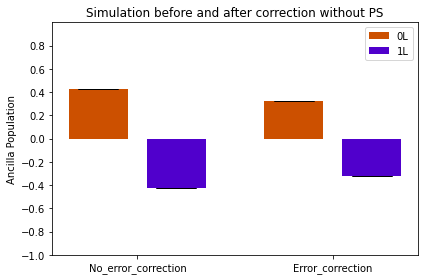

In [19]:
#graph with no PS
#graph constants
YMIN = -1.0
YMAX = 1.0
YTICK = 0.2
WIDTH = 0.2
GAP = 1.5
BAR_WIDTH = 10
CAPSIZE = 20
title = TITLE + ' without PS'

x = np.arange(len(cases_list))  # the label locations

fig, ax = plt.subplots()
plt.bar(x - WIDTH, values_list[0], color = '#cc5000', width = WIDTH * GAP, label = labels_list[0])
plt.bar(x + WIDTH, values_list[1], color = '#5000cc', width = WIDTH * GAP, label = labels_list[1])
plt.errorbar(x - WIDTH, values_list[0], yerr = standard_error_list[0], 
             color = 'black', fmt = 'none', elinewidth = BAR_WIDTH, capsize = CAPSIZE )
plt.errorbar(x + WIDTH, values_list[1], yerr = standard_error_list[1], 
             color = 'black', fmt = 'none', elinewidth = BAR_WIDTH, capsize = CAPSIZE )

ax.set_ylabel('Ancilla Population')
ax.set_title(title)
ax.set_xticks(x)
ax.set_xticklabels(cases_list)
ax.legend()

plt.ylim(YMIN, YMAX)
plt.yticks(np.arange(YMIN, YMAX, YTICK))

fig.tight_layout()

fname = './graphs/' + title
plt.savefig(fname)

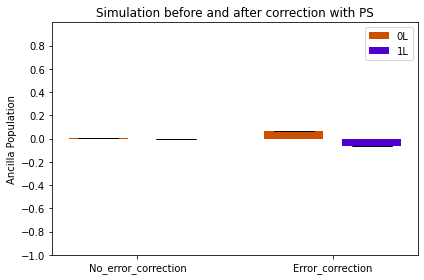

In [17]:
#graph with PS
#graph constants
YMIN = -1.0
YMAX = 1.0
YTICK = 0.2
WIDTH = 0.2
GAP = 1.5
BAR_WIDTH = 10
CAPSIZE = 20
title = TITLE + ' with PS'

x = np.arange(len(cases_list))  # the label locations

fig, ax = plt.subplots()
plt.bar(x - WIDTH, values_list[2], color = '#cc5000', width = WIDTH * GAP, label = labels_list[0])
plt.bar(x + WIDTH, values_list[3], color = '#5000cc', width = WIDTH * GAP, label = labels_list[1])
plt.errorbar(x - WIDTH, values_list[2], yerr = standard_error_list[2], 
             color = 'black', fmt = 'none', elinewidth = BAR_WIDTH, capsize = CAPSIZE )
plt.errorbar(x + WIDTH, values_list[3], yerr = standard_error_list[3], 
             color = 'black', fmt = 'none', elinewidth = BAR_WIDTH, capsize = CAPSIZE )

ax.set_ylabel('Ancilla Population')
ax.set_title(title)
ax.set_xticks(x)
ax.set_xticklabels(cases_list)
ax.legend()

plt.ylim(YMIN, YMAX)
plt.yticks(np.arange(YMIN, YMAX, YTICK))

fig.tight_layout()

fname = './graphs/' + title
plt.savefig(fname)

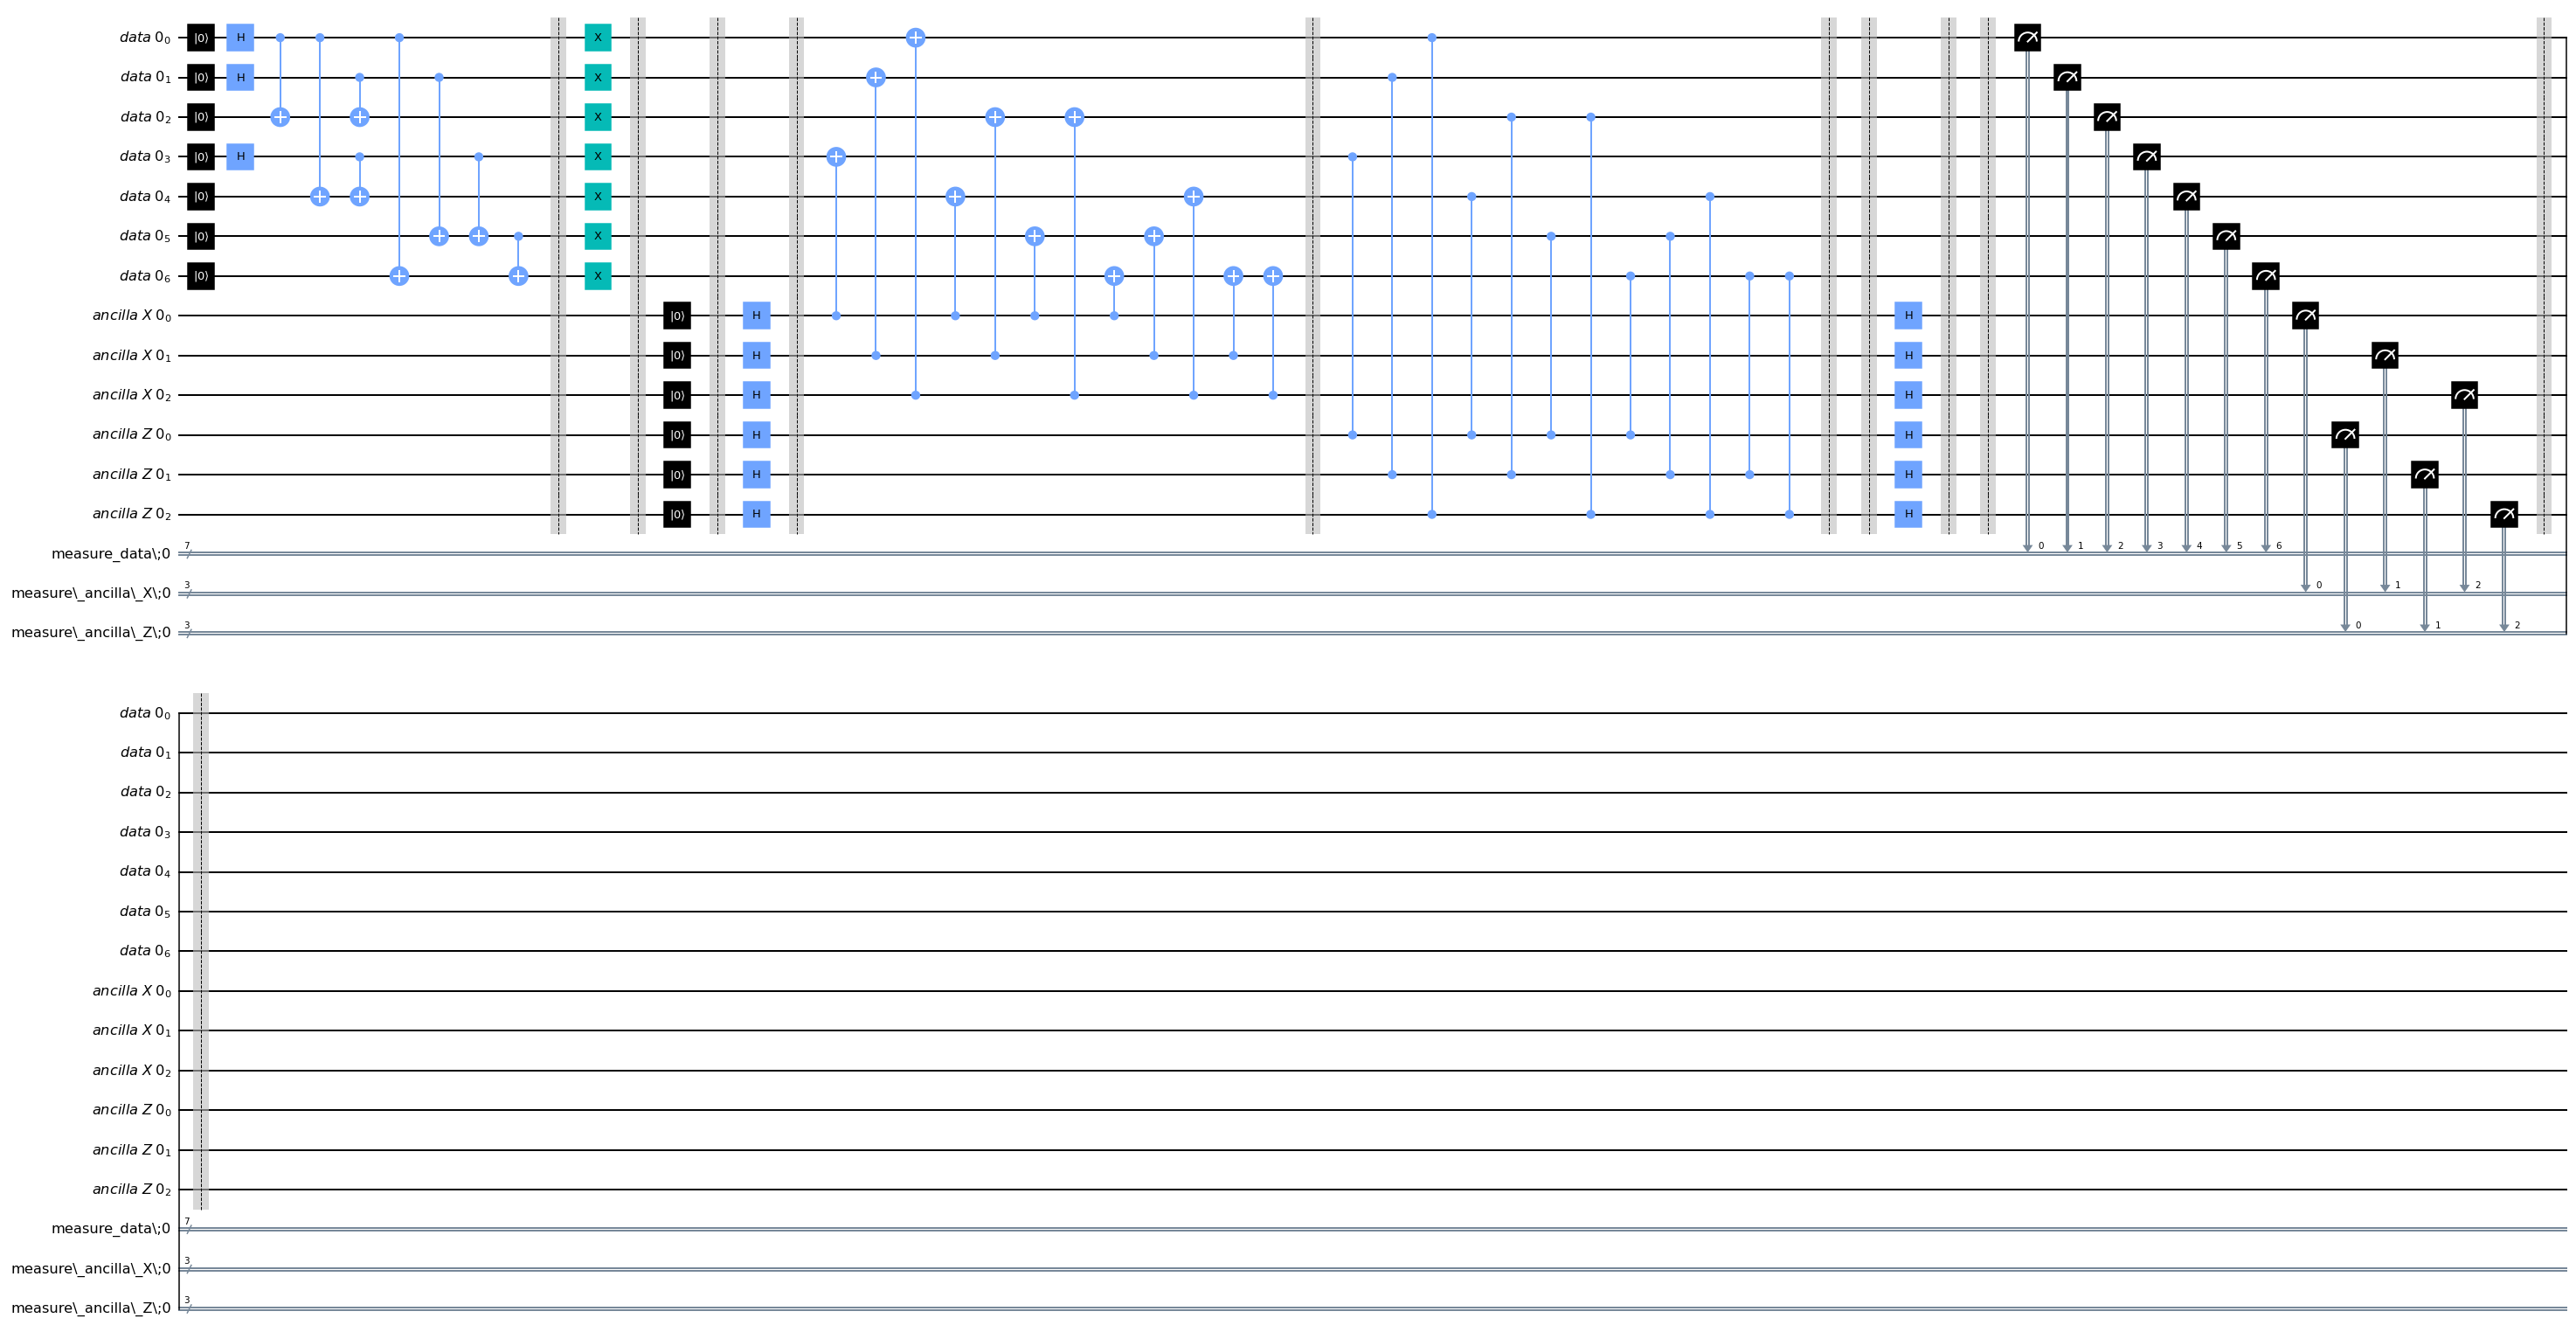

In [18]:
qubit.draw(output = 'mpl', filename = './circuits/Steane_code_error_detection_circuit.jpg', fold = 60)

In [12]:
qt.draw(output = 'mpl', filename = './circuits/Steane_code_error_detection_circuit_transpiled.jpg', fold = 60)

NameError: name 'qt' is not defined